In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('2hp_all_faults_1750.csv')

In [3]:
df = df[df['fault'] != '21_OR2']
df = df[df['fault'] != '21_OR3']
df = df[df['fault'] != '7_OR2']
df = df[df['fault'] != '7_OR3']

In [4]:
df['fault'].unique()

array(['21_BA', 'N', '21_IR', '21_OR1', '14_BA', '7_IR', '7_OR1', '14_IR',
       '7_BA', '14_OR1'], dtype=object)

In [5]:
np.random.normal(0, 1, df.shape[0])
signal_energy = np.mean(df['DE_data']**2)
print(signal_energy)
white_noise_1 = np.clip(np.random.normal(0, 1, df.shape[0]), -1.2, 1.035) # -4.5
signal_energy = np.mean(df['DE_data']**2)
noise_energy = np.mean(white_noise_1**2)
SNR =  10*np.log10(signal_energy/noise_energy)
print(SNR)

0.23307969559679226
-4.007237291832104


In [6]:
df['DE_data'] = df['DE_data'] + white_noise_1

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1200
stride=300

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
print(X.shape)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

(16205, 1, 1200)


In [8]:
X.shape

(16205, 1200, 1)

In [9]:
import scipy.fft
X_freq = []
for i in range(X.shape[0]):
    X_freq.append(scipy.fft.fft(np.concatenate( X[i], axis=0 )))
X_freq = np.asarray(X_freq)
X_freq=X_freq.reshape((X.shape[0],-1,1))

In [10]:
X_freq.shape

(16205, 1200, 1)

In [11]:
X_freq[0]

array([[-21.03734923 -0.j        ],
       [  5.91791462+19.41893165j],
       [ 37.99990137-24.98901067j],
       ...,
       [ 10.40174788-26.3113668j ],
       [ 37.99990137+24.98901067j],
       [  5.91791462-19.41893165j]])

In [12]:
# import scipy.fft
# A_signal_fft = scipy.fft.fft(concatop)
# frequencies = scipy.fft.fftfreq(A_signal_fft.size, 1/48e3)

# fig=plt.figure(2, figsize=(15,6))
# plt.clf()
# plt.plot(frequencies, np.abs(A_signal_fft), lw=1.0, c='paleturquoise')
# plt.stem(frequencies, np.abs(A_signal_fft))
# plt.xlabel("frequency [Hz]")
# plt.ylabel("amplitude [a.u.]")
# plt.title(r"$|\mathcal{F}(A_{signal})|$")

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.2,random_state=42)


In [14]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
from sklearn.model_selection import train_test_split
X_train_freq,X_test_freq,y_train_freq,y_test_freq = train_test_split(X_freq,OHE_Y,test_size=0.2,random_state=42)

In [16]:
y_test_freq

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from tensorflow.keras.layers import LSTM,Bidirectional
from keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

#model 1
model_1D = Input(shape=(X.shape[1],X.shape[2]))
conv1 = Conv1D(filters=16, kernel_size=200, activation='relu')(model_1D)
pool1 = MaxPooling1D(pool_size=2)(conv1)
bat1 = BatchNormalization()(pool1)
conv2 = Conv1D(filters=32, kernel_size=100, activation='relu')(bat1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
bat2 = BatchNormalization()(pool2)
conv3 = Conv1D(filters=16, kernel_size=50, activation='relu')(bat2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
drop1 = Dropout(0.5)(pool3)
lstm1 = LSTM(64)(drop1)
flat1 = Flatten()(lstm1)

#model 2
model2_1D = Input(shape=(X_freq.shape[1],X_freq.shape[2]))
conv1_freq = Conv1D(filters=16, kernel_size=200, activation='relu')(model2_1D)
pool1_freq = MaxPooling1D(pool_size=2)(conv1_freq)
bat1_freq = BatchNormalization()(pool1_freq)
conv2_freq = Conv1D(filters=32, kernel_size=100, activation='relu')(bat1_freq)
pool2_freq = MaxPooling1D(pool_size=2)(conv2_freq)
bat2_freq = BatchNormalization()(pool2_freq)
conv3_freq = Conv1D(filters=16, kernel_size=50, activation='relu')(bat2_freq)
pool3_freq = MaxPooling1D(pool_size=2)(conv3_freq)
drop1_freq = Dropout(0.5)(pool3_freq)
lstm1_freq = LSTM(64)(drop1_freq)
flat1_freq = Flatten()(pool3_freq)


merged = concatenate([flat1, flat1_freq])
dense1 = Dense(300, activation='relu')(merged)
dense2 = Dense(64, activation='relu')(lstm1)
outputs = Dense(no_classes, activation='softmax')(dense2)
# interpretation
model_combined = Model(inputs=[model_1D, model2_1D], outputs=outputs)

model_combined.summary()

model_combined.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1200, 1)]    0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 1001, 16)     3216        ['input_13[0][0]']               
                                                                                                  
 max_pooling1d_36 (MaxPooling1D  (None, 500, 16)     0           ['conv1d_36[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 500, 16)     64          ['max_pooling1d_36[0][0]'] 

In [24]:
batch_size =300
epochs = 70
history = model_combined.fit((X_train,X_train_freq),y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1,shuffle=True)

2022-06-04 19:17:23.725245: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/70
39/39 [==============================] - 19s 459ms/step - loss: 0.4451 - accuracy: 0.1584 - val_loss: 0.3245 - val_accuracy: 0.1087
Epoch 2/70
39/39 [==============================] - 18s 464ms/step - loss: 0.2795 - accuracy: 0.2983 - val_loss: 0.2976 - val_accuracy: 0.2953
Epoch 3/70
39/39 [==============================] - 19s 499ms/step - loss: 0.2324 - accuracy: 0.4313 - val_loss: 0.3642 - val_accuracy: 0.2884
Epoch 4/70
39/39 [==============================] - 20s 510ms/step - loss: 0.2000 - accuracy: 0.5057 - val_loss: 0.3854 - val_accuracy: 0.2938
Epoch 5/70
39/39 [==============================] - 21s 529ms/step - loss: 0.1775 - accuracy: 0.5709 - val_loss: 0.3814 - val_accuracy: 0.3662
Epoch 6/70
39/39 [==============================] - 22s 566ms/step - loss: 0.1596 - accuracy: 0.6201 - val_loss: 0.4134 - val_accuracy: 0.3971
Epoch 7/70
39/39 [==============================] - 25s 652ms/step - loss: 0.1483 - accuracy: 0.6431 - val_loss: 0.4652 - val_accuracy: 0.3901

[0.1282919943332672, 0.8438753485679626]
Test loss: 0.1282919943332672
Test accuracy: 0.8438753485679626


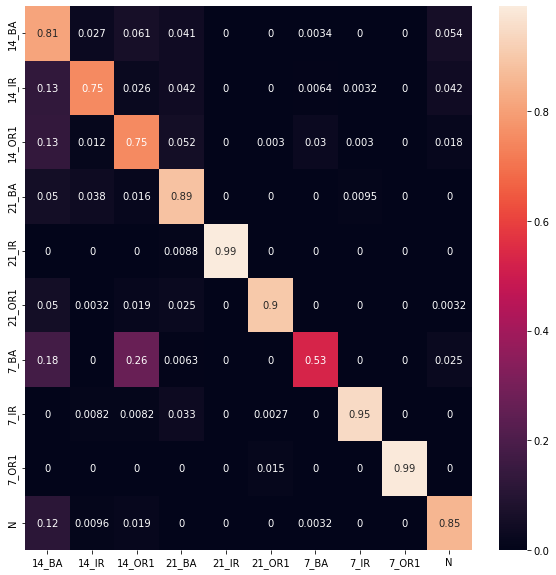

In [25]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



# y_pred=cnn_model.predict(X_test)

# score = cnn_model.evaluate(X_test, y_test, verbose = 0) 

y_pred=model_combined.predict([X_test,X_test_freq])

score = model_combined.evaluate([X_test,X_test_freq], [y_test,y_test_freq], verbose = 0) 
print(score)
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)


print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [26]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall 

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

recall = recall_m(y_test,y_pred)

print("Recall: ",recall)
print("Precision: ",precision_m(y_test,y_pred))
print("F1 Score: " ,f1_m(y_test,y_pred))

Recall:  tf.Tensor(0.8423326, shape=(), dtype=float32)
Precision:  tf.Tensor(0.84598696, shape=(), dtype=float32)
F1 Score:  tf.Tensor(0.8441557, shape=(), dtype=float32)


In [35]:
dummy_combined_model = Model(inputs=model_combined.input,outputs=model_combined.layers[8].output)
y_viz = dummy_combined_model.predict(X_train,X_train_freq)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

NameError: name 'y_viz' is not defined